#data make

In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 13

p = 0.95        #マハラノビス距離p=0.95で2σ
md_sikii = 2.448#MDの閾値95%で2.448
div = 50        #Mt楕円の分割数

class MT:
    def __init__(self, x):
        self.avg = np.zeros(x.shape[1])
        self.std = np.zeros(x.shape[1])

        for i in range(x.shape[1]):
            self.avg[i] = np.mean(x[:,i])
        for i in range(x.shape[1]):
            self.std[i] = np.std(x[:,i])

        self.R = np.corrcoef(x.transpose())
        self.invR = np.linalg.inv(self.R)

    def maha(self, x):
        xx = np.copy(x)
        xx = np.array(xx,dtype="float32")

        #各状態量から平均値を引く
        for i in range(x.shape[1]):
            xx[:,i] = xx[:,i] - self.avg[i]

        #各状態量を標準偏差で割る
        for i in range(x.shape[1]):
            xx[:,i] = xx[:,i] / self.std[i]

        #MD^2の計算
        x_return = []
        for i in range(x.shape[0]):
            d0 = xx[i,:]
            d1 = np.dot(d0,self.invR)
            d2 = np.dot(d1,d0)/x.shape[1]
            x_return.append(np.sqrt(d2))

        return x_return

def make_training_data():
    curve_c = np.zeros((2,div+1))

    #正常データの作成
    x1 = np.random.normal(1, 0.3, (1, 100))
    y1 = np.random.normal(1, 0.3, (1, 100))
    x2 = np.random.normal(1.5, 0.3, (1, 100))
    y2 = np.random.normal(1.5, 0.3, (1, 100))

    #テストデータの作成
    test1 = np.array([1.02,1.5])
    test1 = test1.reshape((1,2))
    test2 = np.array([0.5,2])
    test2 = test2.reshape((1,2))

    #正常データの形を整える
    data = []
    data.append(x1)
    data.append(x2)
    data.append(y1)
    data.append(y2)
    data = np.array(data)
    data = data.reshape(2,200)
    data = data.transpose()
    print(data.shape)

    #単位空間の作成
    mt = MT(data)

    #テストデータのマハラノビス距離
    md_1 = mt.maha(test1)
    md_2 = mt.maha(test2)

    #楕円のデータ
    low = np.corrcoef(data[:,0],data[:,1])[0,1]

    for i in range(div+1):
        r = (-2*(1-low**2)*np.log(1-p)/(1-2*low*np.sin(i*2*np.pi/div)*np.cos(i*2*np.pi/div)))**0.5
        curve_c[0,i] = mt.avg[0] + mt.std[0]*r*np.cos(i*2*np.pi/div)
        curve_c[1,i] = mt.avg[1] + mt.std[1]*r*np.sin(i*2*np.pi/div)

    #可視化
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.scatter(x1, y1, c="green", s=50)
    plt.scatter(x2, y2, c="green", s=50)
    plt.scatter(test1[:,0],test1[:,1],c="m", s=50,label="Test_normal")
    plt.scatter(test2[:,0],test2[:,1],c="red", s=50, label="Test_anomaly")
    plt.xlabel("x_1")
    plt.ylabel("x_2")

    plt.plot(curve_c[0],curve_c[1],c="c")
    plt.legend()

    plt.subplot(1,2,2)
    plt.bar([1,2], [md_1[0], md_2[0]], align="center")
    plt.xticks([1,2], ["Test_normal", "Test_anomaly"])
    plt.ylabel("MD")
    plt.grid(True)

    plt.show()

    return data, test1, test2

#MT and IsolationForest

In [0]:
from sklearn.ensemble import IsolationForest
    
def add_data(train, normal, anomaly, num, MT=True, fig=False):
    temp_train = np.copy(train)
    temp_normal = np.copy(normal)
    temp_anomaly = np.copy(anomaly)

    for i in range(num):
        if MT:
            temp_train, temp_normal, temp_anomaly, score_normal, score_anomaly = mt_add_data(temp_train, temp_normal, temp_anomaly, fig)
        else:
            temp_train, temp_normal, temp_anomaly, score_normal, score_anomaly = IF_add_data(temp_train, temp_normal, temp_anomaly, fig)

    return temp_train, temp_normal, temp_anomaly, score_normal, score_anomaly
        
def mt_add_data(data, normal, anomaly, fig=True):
    y1 = np.random.normal(0, 0.1, (200, 1))
    y_normal = np.random.normal(0, 0.1,(1,1))
    y_anomaly = np.random.normal(0, 0.1,(1,1))

    data_new = np.hstack((data,y1))
    test1_new = np.hstack((normal, y_normal))
    test2_new = np.hstack((anomaly, y_anomaly))

    #単位空間の作成
    mt = MT(data_new)

    #テストデータのマハラノビス距離
    md_1 = mt.maha(test1_new)
    md_2 = mt.maha(test2_new)

    if fig == True:
        plot(data_new, test1_new, test2_new, md_1[0], md_2[0])

    return data_new, test1_new, test2_new, md_1, md_2

def IF_add_data(data, normal, anomaly, fig=False):
    y1 = np.random.normal(0, 0.1, (200, 1))
    y_normal = np.random.normal(0, 0.1,(1,1))
    y_anomaly = np.random.normal(0, 0.1,(1,1))

    data_new = np.hstack((data,y1))
    test1_new = np.hstack((normal, y_normal))
    test2_new = np.hstack((anomaly, y_anomaly))

    # training
    IF = IsolationForest(n_estimators=100, max_samples=50)
    IF.fit(data_new)
    
    # score
    score1 = -IF.decision_function(test1_new)[0]
    score2 = -IF.decision_function(test2_new)[0]

    if fig == True:
        plot(data_new, test1_new, test2_new, score1, score2)

    return data_new, test1_new, test2_new, score1, score2

def plot(data, test_normal, test_anomaly, score1, score2):
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.scatter(np.arange(len(data)), data[:,0],  s=50, label="Train_data")
    plt.scatter(len(data)+1, test_normal[:,0],c="m", s=50,label="Test_normal")
    plt.scatter(len(data)+2, test_anomaly[:,0],c="red", s=50, label="Test_anomaly")
    plt.plot(np.hstack((np.hstack((data[:,0], test_normal[:,0])), test_anomaly[:,0])))
    plt.legend()
    plt.xlabel("Data No.")
    plt.title("x_1")
    plt.ylabel("x_1")

    plt.subplot(1,3,2)
    plt.scatter(np.arange(len(data)), data[:,1], s=50, label="Train_data")
    plt.scatter(len(data)+1, test_normal[:,1],c="m", s=50,label="Test_normal")
    plt.scatter(len(data)+2, test_anomaly[:,1],c="red", s=50, label="Test_anomaly")
    plt.plot(np.hstack((np.hstack((data[:,1], test_normal[:,-1])), test_anomaly[:,-1])))
    plt.legend()
    plt.xlabel("Data No.")
    plt.title("x_2")
    plt.ylabel("x_2")

    plt.subplot(1,3,3)
    plt.scatter(np.arange(len(data)), data[:,-1], s=50, label="Train_data")
    plt.scatter(len(data)+1, test_normal[:,-1],c="m", s=50,label="Test_normal")
    plt.scatter(len(data)+2, test_anomaly[:,-1],c="red", s=50, label="Test_anomaly")
    plt.plot(np.hstack((np.hstack((data[:,-1], test_normal[:,-1])), test_anomaly[:,-1])))
    plt.legend()
    plt.xlabel("Data No.")
    plt.title("x_3")
    plt.ylabel("x_3")

    plt.show()

    plt.figure()
    plt.scatter(data[:,0], data[:,-1], c="green", s=50)
    plt.scatter(test_normal[:,0], test_normal[:,-1],c="m", s=50,label="normal")
    plt.scatter(test_anomaly[:,0], test_anomaly[:,-1],c="red", s=50, label="anomaly")
    plt.legend()
    plt.xlabel("x_1")
    plt.ylabel("x_3")

    plt.show()

    #plt.figure(figsize=(10,5))
    plt.bar([1,2], [score1, score2], align="center")
    plt.xticks([1,2], ["Normal", "Anomaly"])
    plt.ylabel("Score")
    plt.grid(True)

    plt.show()

#MT

(200, 2)


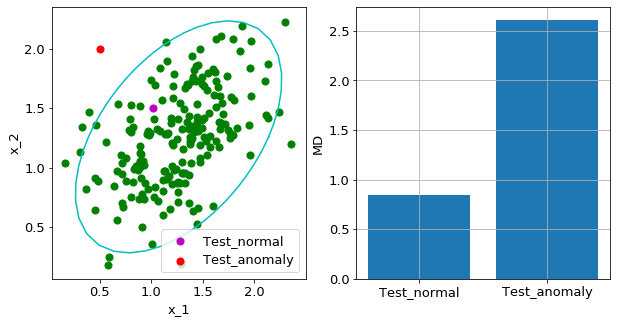

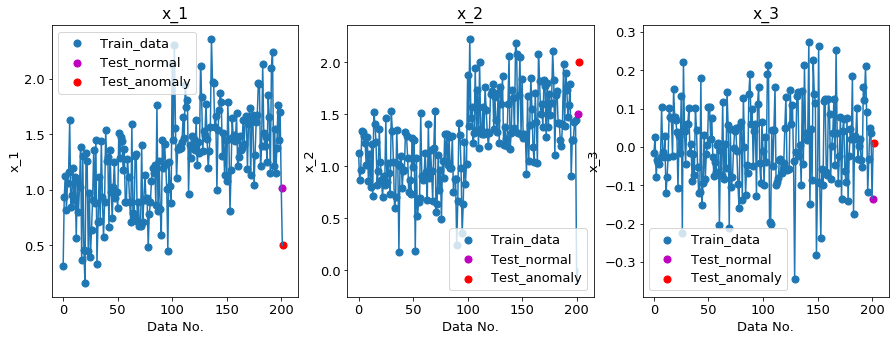

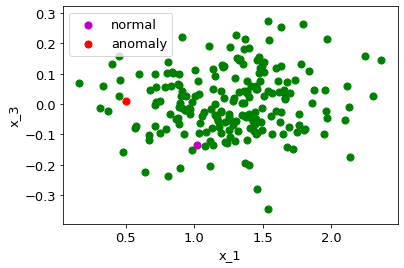

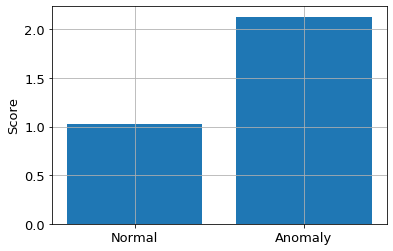

In [0]:
x_train, x_normal, x_anomaly = make_training_data()

sample = [1,2,2,2,10,10,10,10,50]
data_size = []

score_normal, score_anomaly = [], []
x_train, x_normal, x_anomaly, temp_normal, temp_anomaly = add_data(x_train, x_normal, x_anomaly, 1, MT=True, fig=True)
score_normal.append(temp_normal[0])
score_anomaly.append(temp_anomaly[0])
data_size.append(1+2)

for i in range(len(sample)):
    x_train, x_normal, x_anomaly, temp_normal, temp_anomaly = add_data(x_train, x_normal, x_anomaly, sample[i], MT=True)
    score_normal.append(temp_normal[0])
    score_anomaly.append(temp_anomaly[0])
    data_size.append(data_size[-1]+sample[i])

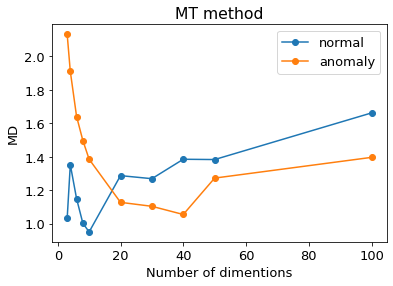

In [0]:
plt.plot(data_size, score_normal, label="normal", marker="o")
plt.plot(data_size, score_anomaly, label="anomaly", marker="o")
plt.title("MT method")
plt.ylabel("MD")
plt.xlabel("Number of dimentions")
plt.legend()
plt.show()

#Isolation Forest

(200, 2)


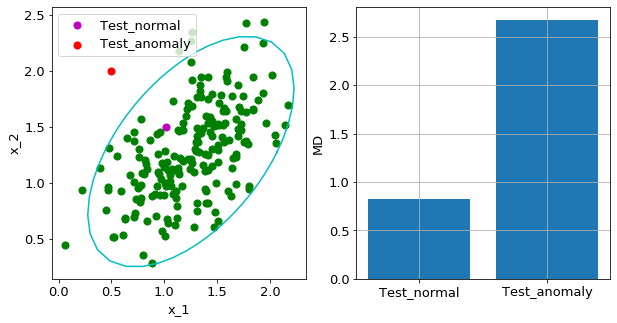

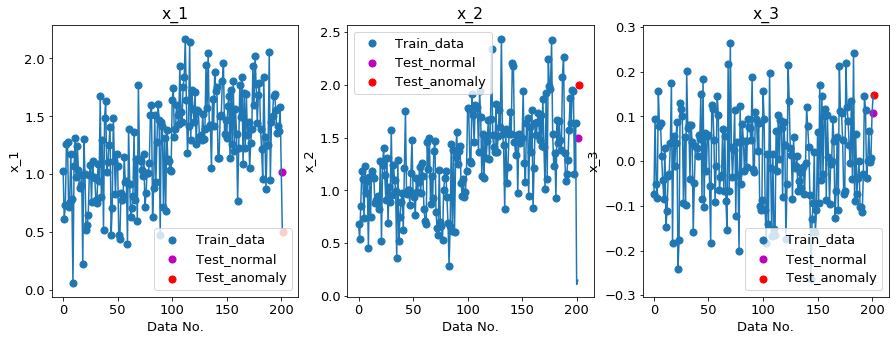

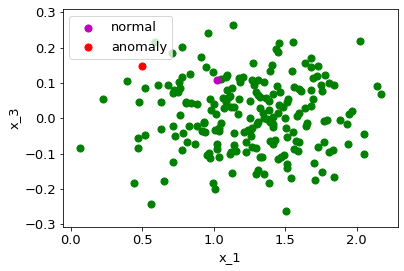

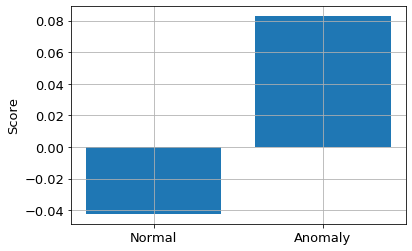

In [0]:
x_train, x_normal, x_anomaly = make_training_data()

sample = [1,2,2,2,10,10,10,10,50]
data_size = []

score_normal, score_anomaly = [], []
x_train, x_normal, x_anomaly, temp_normal, temp_anomaly = add_data(x_train, x_normal, x_anomaly, 1, MT=False, fig=True)
score_normal.append(temp_normal)
score_anomaly.append(temp_anomaly)
data_size.append(1+2)

for i in range(len(sample)):
    x_train, x_normal, x_anomaly, temp_normal, temp_anomaly = add_data(x_train, x_normal, x_anomaly, sample[i], MT=False)
    score_normal.append(temp_normal)
    score_anomaly.append(temp_anomaly)
    data_size.append(data_size[-1]+sample[i])

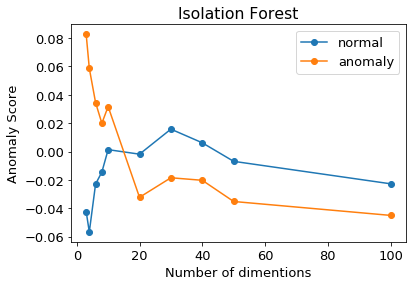

In [0]:
plt.plot(data_size, score_normal, label="normal", marker="o")
plt.plot(data_size, score_anomaly, label="anomaly", marker="o")
plt.title("Isolation Forest")
plt.ylabel("Anomaly Score")
plt.xlabel("Number of dimentions")
plt.legend()
plt.show()